# Traffic sign detection and classification (with deep learning)
Reset kernel

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Dependencies
Install dependencies. Adapt this to your linux distro/windows machine. Don't forget to restart the kernel to update the installed python packages.

In [13]:
%%capture
# Adapt adp-get to your distro
!pip install -U jupyter
!apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv unzip
!pip install opencv-python torchvision torchaudio albumentations kaggle tdqm torchsummary
!pip install --upgrade --quiet jupyter_client ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Download dataset. I've created an account for this task, so please don't abuse this API key, thx.

In [5]:
%%capture
!mkdir -p ~/.kaggle
!echo "{\"username\":\"vcguy2022\",\"key\":\"58a013ff978771be5b85417b3ee3917c\"}"  > /root/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/road-sign-detection
!unzip road-sign-detection -d dataset/;

In [54]:
import cv2 as cv
import os
import random
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from utils import plotTrainingHistory
from torchsummary import summary
import matplotlib.pyplot as plt

Define your images and annotations directory here

In [31]:
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

Load train and val images and shufflte them

In [32]:
# Get train and validation datasets

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)

#displayImage(importImage(train_images_filenames[0])), displayImage(importImage(val_images_filenames[0]))
len(train_images_filenames), len(val_images_filenames)

(613, 264)

Define functions to visualize images

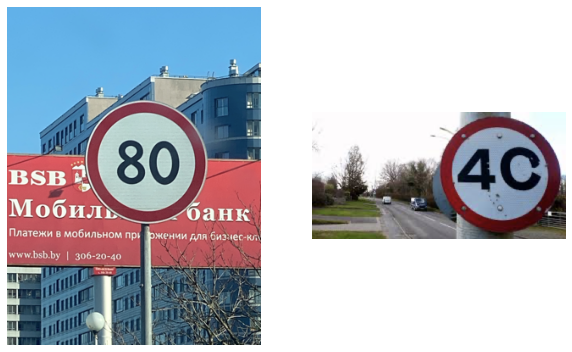

In [39]:
def importImage(name):
    from os import path
    image = cv.imread(path.join(images_directory, name + ".png"))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def displayImage(*names, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(names))
    for index, name in enumerate(names):
        axs[index].imshow(importImage(name))
        axs[index].axis('off')
    
    plt.title(title)
    plt.show()

displayImage(train_images_filenames[0], val_images_filenames[0])

## Load Dataset

For this, we define the classes that we want to predict and we define a dataset class, show bellow

In [40]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self._get_max_area_class_from_annotion(image_filename)

    def _get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

Define transforms

In [41]:
def get_transform(input_size):
    train_transform = A.Compose([
        A.RandomResizedCrop(input_size, input_size),
        A.HorizontalFlip(),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, val_transform


Get dataloaders according to desired image size, which will vary according to the expected input size of the network

In [42]:
def get_dataloaders(input_size):
    train_transform, val_transform = get_transform(input_size)
    train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Define batch size and num workers

In [43]:
batch_size = 128
num_workers = 0 # How many processes are used to load the data

Define device

In [7]:
num_classes = len(classes)

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Training

We define a model trainer class, which will help us to train each model more easily

In [ ]:

class ModelTrainer:
    def __init__(self, *args):
        if len(args) == 5:
            model, model_name, loss, optimizer, device = args
        elif len(args) == 2:
            ks = ["model", "name", "num_epochs", "loss", "optimizer"]
            model, model_name, num_epochs, loss, optimizer = [args[0][k] for k in ks]
            device = args[1]

        self.model = model
        self.model_name = model_name
        self.num_epochs = num_epochs
        self.loss = loss
        self.optimizer = optimizer
        self.device = device

    def predict_data(self, data):
        print("Predicting data")
        preds = []
        actuals = []
        with torch.set_grad_enabled(False):
            for _, (X, y) in enumerate(tqdm(data)):
                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred)
                actuals.extend(y)
        return torch.stack(preds, dim=0), torch.stack(actuals, dim=0)

    def _epoch_iter(self, dataloader, is_train):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            for batch, (X, y) in enumerate(tqdm(dataloader)):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred.cpu().numpy())
                labels.extend(y.cpu().numpy())

        return total_loss / num_batches, accuracy_score(labels, preds)
    
    def _save_model(self, t, file_name):
        save_dict = {'model': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, self.model_name + f'_{ file_name }.pth')

    def train(self, train_dataloader, validation_dataloader, force_load_model=True):
        from os.path import exists
        file_exists = exists(self.model_name + '_latest_model.pth')
        if file_exists:
            if not force_load_model:
                print("File already exists do you wish to overwrite (Y/N)?")
                ans = input()
            if force_load_model or not (ans == 'Y' or ans == 'y'):
                # Load model and display previous results
                dic = torch.load(self.model_name + '_best_model.pth')
                self.model.load_state_dict(dic['model'])
                print(f"Loaded { self.model_name } obtained in epoch { dic['epoch'] }")
                self.model.eval()
                with open(self.model_name + '_train_history.json', 'r') as f:
                    train_history = json.load(f)
                with open(self.model_name + '_val_history.json', 'r') as f:
                    val_history = json.load(f)
                return train_history, val_history


        train_history = {'loss': [], 'accuracy': []}
        val_history = {'loss': [], 'accuracy': []}
        best_val_loss = np.inf
        print("Start training...")

        for t in range(self.num_epochs):
            print(f"\nEpoch {t+1}")

            # Train
            train_loss, train_acc = self._epoch_iter(train_dataloader, True)

            print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")

            # Test
            val_loss, val_acc = self._epoch_iter(validation_dataloader, False)
            print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

            # Save model when validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model(t, 'best_model')

            # Save latest model
            self._save_model(t, 'best_model')

            # save training history for plotting purposes
            train_history["loss"].append(train_loss)
            train_history["accuracy"].append(train_acc)

            val_history["loss"].append(val_loss)
            val_history["accuracy"].append(val_acc)

        print("Finished")
        with open(self.model_name + '_train_history.json', 'w') as f:
            f.write(json.dumps(train_history))

        with open(self.model_name + '_val_history.json', 'w') as f:
            f.write(json.dumps(val_history))

        return train_history, val_history

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_fc(self):
        self.model.fc.weight.requires_grad = True

    def visualize_model(self, val_dataloader, classes, num_images=6): # Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
        was_training = self.model.training
        self.model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    class_names = list(classes.keys())
                    ax.set_title(f'predicted: {class_names[preds[j]]}')
                    cv.imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        self.model.train(mode=was_training)
                        return
            self.model.train(mode=was_training)

### ResNet-50
ResNet expects an input size of 224

In [44]:
input_size = 224

We define a baseline with 10 epochs, cross entropy loss, and SGD optimizer

In [51]:
resnet_model = models.resnet50(pretrained=True)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model.to(device)

resnet = {
    "model": resnet_model,
    "name": 'resnet50',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model.parameters(), lr=1e-2)
}

summary(resnet["model"], (3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Use transfer learning - train only last layer

  0%|          | 0/4 [00:00<?, ?it/s]

Start training...

Epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.764 	 Train acc: 0.732


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.910 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.772 	 Train acc: 0.729


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 0.919 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.762 	 Train acc: 0.732


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.878 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.731 	 Train acc: 0.730


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.853 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.747 	 Train acc: 0.727


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 0.825 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.744 	 Train acc: 0.719


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 0.809 	 Val acc: 0.735


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.736 	 Train acc: 0.727


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.798 	 Val acc: 0.742


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.712 	 Train acc: 0.748


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.794 	 Val acc: 0.735


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.707 	 Train acc: 0.732


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 0.806 	 Val acc: 0.731


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.705 	 Train acc: 0.738


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.777 	 Val acc: 0.742
Finished


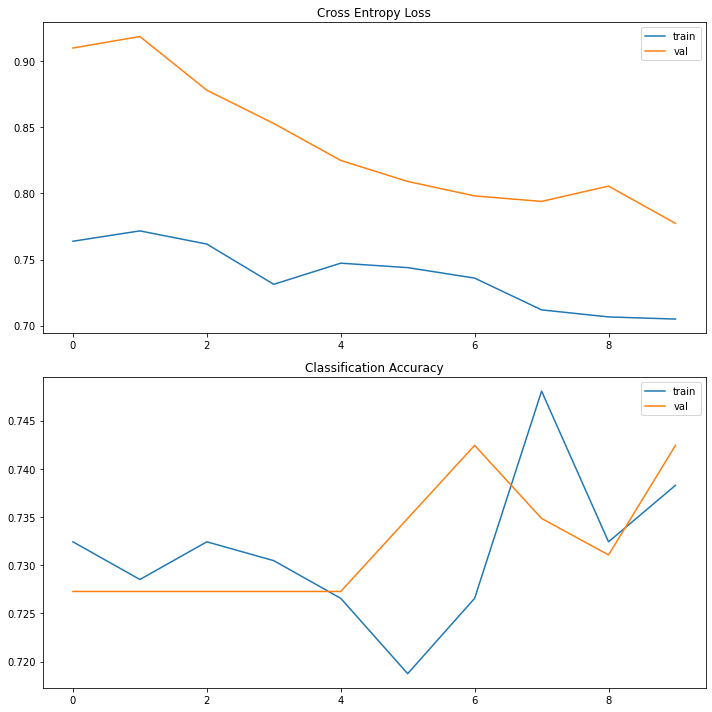

In [53]:
resnet_trainer = ModelTrainer(resnet, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()
resnet_train_history, resnet_val_history = resnet_trainer.train(train_dataloader, val_dataloader, force_load_model=True)
plotTrainingHistory(resnet_train_history, resnet_val_history)

Perform fine tunning - unfreeze all layers and train with a small learning rate a small number of epochs

  0%|          | 0/4 [00:00<?, ?it/s]

Start training...

Epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.687 	 Train acc: 0.758


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.777 	 Val acc: 0.750


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.688 	 Train acc: 0.760


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.772 	 Val acc: 0.754


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.712 	 Train acc: 0.742


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 0.768 	 Val acc: 0.754
Finished


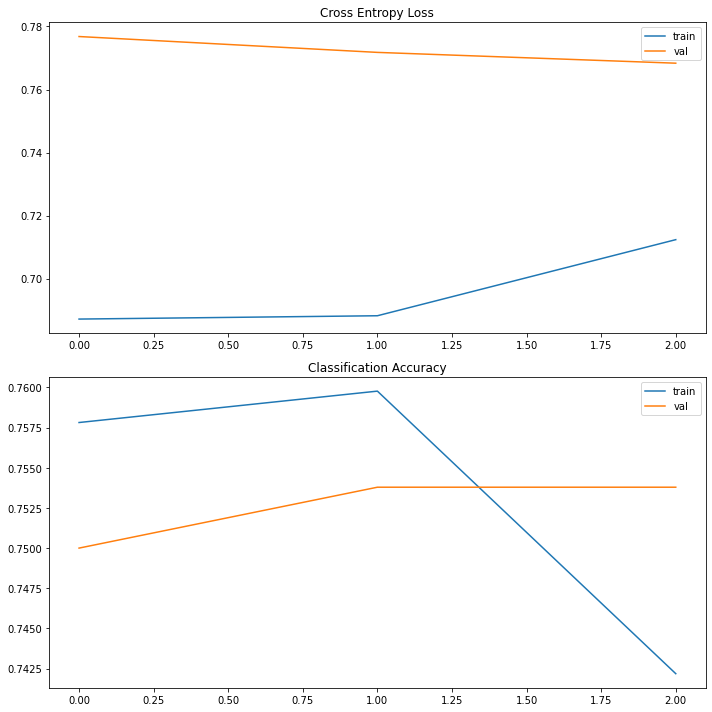

In [55]:
resnet_trainer.optimizer = torch.optim.SGD(resnet_model.parameters(), lr=1e-7)
resnet_trainer.num_epochs = 3 
resnet_trainer.unfreeze_layers()
resnet_train_history, resnet_val_history = resnet_trainer.train(train_dataloader, val_dataloader, force_load_model=False)
plotTrainingHistory(resnet_train_history, resnet_val_history)

In [11]:
from torchmetrics import MetricCollection, Accuracy, Precision, Recall
metric_collection = MetricCollection([
    Accuracy(),
    Precision(num_classes=num_classes, average='macro'),
    Recall(num_classes=num_classes, average='macro')
])
metric_collection(preds, actual_y)

{'Accuracy': tensor(0.6970), 'Precision': tensor(0.1797), 'Recall': tensor(0.2396)}


### VGG-16

In [ ]:
# Load model from torchvision (with pretrained=True)
vgg_model = models.vgg16(pretrained=True)
# Change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg_model.classifier[6] = nn.Linear(4096, num_classes)
vgg_model.to(device)

vgg = {
    "model": vgg_model,
    "name": 'vgg16',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(vgg_model.parameters(), lr=1e-3)
}
print(vgg)

Only train last layers

Train from scratch

In [ ]:
vg_trainer = ModelTrainer(vgg, device)
vgg_train_history, vgg_val_history = vg_trainer.train(train_dataloader, val_dataloader)

plotTrainingHistory(vgg_train_history, vgg_val_history)